In [11]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
import os

# checking if gpu is available to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [13]:
data = pd.read_csv("../data/cleaned_household_power_consumption.csv", parse_dates=["DateTime"], index_col="DateTime")

#downsample data to daily frequency
data = data.resample('D').mean()

scaler = StandardScaler()
data['Global_active_power'] = scaler.fit_transform(data[['Global_active_power']])



In [14]:
#parameters
sequence_length = 30  # 30-day window
batch_size = 32
train_size = int(len(data) * 0.8)

#helper function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length][0]  # foR Next day's power
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# train and test sets split
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

X_train, y_train = create_sequences(train_data.values, sequence_length)
X_test, y_test = create_sequences(test_data.values, sequence_length)

# convert to pytorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

#create DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)


In [15]:
class EnhancedTimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=8, num_layers=4, dim_feedforward=128, dropout=0.3):
        super(EnhancedTimeSeriesTransformer, self).__init__()
        # Input projection layer with increased d_model
        self.input_layer = nn.Linear(input_dim, d_model)
        # Transformer Encoder Layers
        self.encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layers, num_layers=num_layers)
        # Output layer
        self.fc_out = nn.Linear(d_model, 1)  # Output layer for single target prediction

    def forward(self, src):
        src = self.input_layer(src)  # Shape: [batch_size, sequence_length, d_model]
        src = self.transformer_encoder(src)  # Shape: [batch_size, sequence_length, d_model]
        output = self.fc_out(src[:, -1, :])  # Predict based on the last time step
        return output

# IMP: defining model, loss, and optimizer
input_dim = 7 # since there are 7 features in the dataaset
d_model = 32
nhead = 2
num_layers = 2
dim_feedforward = 64
dropout = 0.1

model = EnhancedTimeSeriesTransformer(input_dim, d_model, nhead, num_layers, dim_feedforward, dropout).to(device)
criterion = nn.MSELoss()


from torch.optim.lr_scheduler import StepLR

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # reduce learning rate by half every 5 epochs


c:\Users\Admin\Desktop\1shChheda\CODING\Time Series\energy-forecasting-project\.venv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [16]:
# to check if X_train and X_test have the correct shape
print("X_train shape:", X_train.shape)  # output [num_sequences, sequence_length, 7]
print("y_train shape:", y_train.shape)  # output [num_sequences, 1]

X_train shape: torch.Size([1123, 30, 7])
y_train shape: torch.Size([1123])


In [17]:
#training
import torch
from torch.optim import AdamW
import numpy as np

num_epochs = 50
patience = 5
best_loss = float('inf')
epochs_without_improvement = 0
model_path = "../models/best_transformer_model.pth"

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # validate model
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()
    val_loss /= len(test_loader)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}")

    # early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), model_path)
        epochs_without_improvement = 0
        print("Model saved.")
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping.")
        break

    #step scheduler
    scheduler.step()


c:\Users\Admin\Desktop\1shChheda\CODING\Time Series\energy-forecasting-project\.venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Admin\Desktop\1shChheda\CODING\Time Series\energy-forecasting-project\.venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Train Loss: 1.0329, Test Loss: 0.6288
Model saved.
Epoch 2, Train Loss: 1.0408, Test Loss: 0.5393
Model saved.
Epoch 3, Train Loss: 1.0145, Test Loss: 0.6021
Epoch 4, Train Loss: 1.0260, Test Loss: 0.5079
Model saved.
Epoch 5, Train Loss: 0.9914, Test Loss: 0.4971
Model saved.
Epoch 6, Train Loss: 0.9880, Test Loss: 0.5456
Epoch 7, Train Loss: 1.0249, Test Loss: 0.5551
Epoch 8, Train Loss: 1.0174, Test Loss: 0.5335
Epoch 9, Train Loss: 1.0190, Test Loss: 0.5766
Epoch 10, Train Loss: 1.0772, Test Loss: 0.5701
Early stopping.


In [18]:
#load best model
model.load_state_dict(torch.load(model_path))

#eval on test data
model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        predictions.extend(output.cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())

# Inverse transform predictions and actuals
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

#saving results
np.save("../models/predictions.npy", predictions)
np.save("../models/actuals.npy", actuals)


C:\Users\Admin\AppData\Local\Temp\ipykernel_17600\1252677632.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


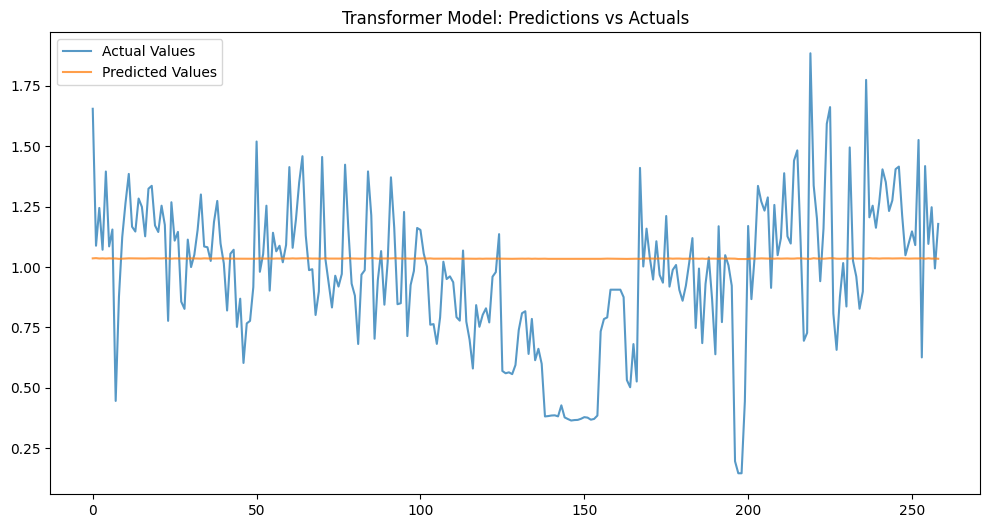

In [19]:
# Plot # predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual Values", alpha=0.75)
plt.plot(predictions, label="Predicted Values", alpha=0.75)
plt.legend()
plt.title("Transformer Model: Predictions vs Actuals")
plt.show()
